In [22]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch import optim
from sklearn.metrics import accuracy_score

# Transformations to apply on the MNIST images
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts the image to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizes the tensor
])

# Download the entire MNIST dataset
full_dataset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)

# Calculate the sizes of each dataset split
total_size = len(full_dataset)
train_size = int(0.9 * total_size)
validation_size = int(0.05 * total_size)
test_size = total_size - train_size - validation_size

# Split the dataset into training, validation, and test sets
train_dataset, validation_dataset, test_dataset = random_split(full_dataset, [train_size, validation_size, test_size])

# Create data loaders for each split
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


In [23]:
# Train loop
def train(model, train_loader, loss_fn, optimizer, epoch=-1):
    """
    Trains a model for one epoch (one pass through the entire training data).

    :param model: PyTorch model
    :param train_loader: PyTorch Dataloader for training data
    :param loss_fn: PyTorch loss function
    :param optimizer: PyTorch optimizer, initialized with model parameters
    :kwarg epoch: Integer epoch to use when printing loss and accuracy
    :returns: Accuracy score
    """
    total_loss = 0
    all_predictions = []
    all_targets = []
    loss_history = []

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(DEVICE)
    model.train()  # Set model in training mode

    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets.to(DEVICE))
        loss.backward()
        optimizer.step()


        # Track some values to compute statistics
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=-1)
        all_predictions.extend(preds.detach().cpu().tolist())
        all_targets.extend(targets.cpu().tolist())

        # Save loss every 100 batches
        if (i % 100 == 0) and (i > 0):
            running_loss = total_loss / (i + 1)
            loss_history.append(running_loss)
            # print(f"Epoch {epoch + 1}, batch {i + 1}: loss = {running_loss:.2f}")

    acc = accuracy_score(all_targets, all_predictions)
    final_loss = total_loss / len(train_loader)
    # Print average loss and accuracy
    print(f"Epoch {epoch + 1} done. Average train loss = {final_loss:.2f}, average train accuracy = {acc * 100:.3f}%")
    return acc, final_loss

In [24]:
def test(model, test_loader, loss_fn, epoch=-1):
    """
    Tests a model for one epoch of test data.

    Note:
        In testing and evaluation, we do not perform gradient descent optimization, so steps 2, 5, and 6 are not needed.
        For performance, we also tell torch not to track gradients by using the `with torch.no_grad()` context.

    :param model: PyTorch model
    :param test_loader: PyTorch Dataloader for test data
    :param loss_fn: PyTorch loss function
    :kwarg epoch: Integer epoch to use when printing loss and accuracy

    :returns: Accuracy score
    """
    total_loss = 0
    all_predictions = []
    all_targets = []

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(DEVICE)
    model.eval()  # Set model in evaluation mode
    for i, (inputs, targets) in enumerate(test_loader):
        with torch.no_grad():
            outputs = model(inputs.to(DEVICE))
            loss = loss_fn(outputs, targets.to(DEVICE))

            # Track some values to compute statistics
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=-1)
            all_predictions.extend(preds.detach().cpu().tolist())
            all_targets.extend(targets.cpu().tolist())

    acc = accuracy_score(all_targets, all_predictions)
    final_loss = total_loss / len(test_loader)
    # Print average loss and accuracy
    print(f"Epoch {epoch + 1} done. Average test loss = {final_loss:.4f}, average test accuracy = {acc * 100:.4f}%")
    return acc, final_loss

In [25]:
# Define the CNN

import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    
    def __init__(self):        
        super(CNN, self).__init__()
        # Image size 1x28x28 (grayscale images)
        # Number of classes = 10 (digits 0 through 9)
        self.conv1 = nn.Conv2d(1, 10, 5)  # Output: 10x24x24
        self.pool1 = nn.MaxPool2d(2, 2)   # Output: 10x12x12
        self.conv2 = nn.Conv2d(10, 20, 5) # Output: 20x8x8
        self.pool2 = nn.MaxPool2d(2, 2)   # Output: 20x4x4
        self.fc1 = nn.Linear(20 * 4 * 4, 50)  # Fully connected layer
        self.fc2 = nn.Linear(50, 10)          # Output layer for 10 classes
        self.out = nn.LogSoftmax(dim=1)       # LogSoftmax for classification

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 20 * 4 * 4)  # Flatten the output for the dense layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.out(x)  # Output layer with LogSoftmax
        return x

In [26]:
LEARNING_RATE = 1e-2
NUM_EPOCHS = 10
torch.manual_seed(0)
model = CNN()
optimizer = optim.Adam(model.parameters(), LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
train_metrics = []
test_metrics = []


for epoch in range(NUM_EPOCHS):
    train_acc, train_loss = train(model, train_loader, loss_fn, optimizer, epoch)
    test_acc, test_loss = test(model, validation_loader, loss_fn, epoch)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_metrics.append(train_acc)
    test_metrics.append(test_acc)
    

Epoch 1 done. Average train loss = 0.15, average train accuracy = 95.511%
Epoch 1 done. Average test loss = 0.0545, average test accuracy = 98.3000%
Epoch 2 done. Average train loss = 0.08, average train accuracy = 97.669%
Epoch 2 done. Average test loss = 0.0617, average test accuracy = 97.9333%
Epoch 3 done. Average train loss = 0.07, average train accuracy = 97.933%
Epoch 3 done. Average test loss = 0.0699, average test accuracy = 98.2000%
Epoch 4 done. Average train loss = 0.07, average train accuracy = 98.126%
Epoch 4 done. Average test loss = 0.0574, average test accuracy = 98.5000%
Epoch 5 done. Average train loss = 0.07, average train accuracy = 98.143%
Epoch 5 done. Average test loss = 0.0493, average test accuracy = 98.8000%
Epoch 6 done. Average train loss = 0.07, average train accuracy = 98.226%
Epoch 6 done. Average test loss = 0.0508, average test accuracy = 98.6000%
Epoch 7 done. Average train loss = 0.07, average train accuracy = 98.217%
Epoch 7 done. Average test loss 

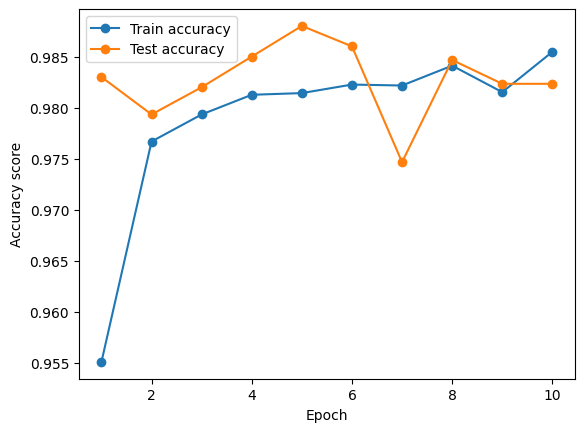

In [28]:
import matplotlib.pyplot as plt

# Plot training curves
xs = 1 + torch.arange(NUM_EPOCHS)
plt.plot(xs, train_metrics, "o-", label="Train accuracy")
plt.plot(xs, test_metrics, "o-", label="Test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy score")
plt.legend()
plt.show()